In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import json
import time
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

import sys
sys.path.append("../..")

import scipy
from scipy.stats import sem
from scipy.io import loadmat

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import tensorflow as tf
import gpflow

from tqdm.notebook import tqdm
import geopandas as gpd
from shapely.geometry import Polygon, Point
import contextily as ctx
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [19]:
# Load the data. Please email the corresponding author for access to the data.
data = loadmat('../../data/dr_paper/EVIVOD_Zhu.mat')
lonLat = loadmat('../../data/dr_paper/latlon_allcrops.mat', squeeze_me=True)

## Data Processing

In [20]:
df = gpd.GeoDataFrame(pd.DataFrame(np.zeros((data["data"]["Y"][0][0].shape[0], 1)), columns=["yield"]))
df["yield"] = data["data"]["Y"][0][0][:,0]
df.crs = {'init':"epsg:4326"}

<ipython-input-20-ac4b3f930132>:3: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  df.crs = {'init':"epsg:4326"}
/home/hbz15/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [21]:
# Check which counties are Polygons

geometry = []
for i in range(385):
    if type(lonLat["lon_county"][i][0]) == np.float64:
        length = 1
    else:
        length = lonLat["lon_county"][i][0].shape[0]
#     print(length)
    if length == 1:
        polygon_geom = Point(lonLat["lon_county"][i][0], lonLat["lat_county"][i][0])
    else:
        polygon_geom = Polygon(zip(lonLat["lon_county"][i][0][:-1], lonLat["lat_county"][i][0][:-1]))
    geometry.append(polygon_geom)
# plt.colorbar()

In [22]:
# Only use data presented in Polygon type

df.geometry = geometry
df["type"] = df["geometry"].apply(lambda v: isinstance(v, Polygon))
df = df[df["type"]]

## Calculate the max number of items in a bag

This step ensures later the ability for mini-batch training for MVBAgg

In [23]:
max_VOD = 0
max_EVI = 0
for i in df.index.values:
    if type(data["data"]["EVI"][0][0][i][0]) == np.float64:
        EVI_length = 1
    else:
        EVI_length = data["data"]["EVI"][0][0][i][0][:-1].shape[0]
        
    if type(data["data"]["VOD"][0][0][i][0]) == np.float64:
        VOD_length = 1
    else:
        VOD_length = data["data"]["VOD"][0][0][i][0][:-1].shape[0]
    max_EVI = max(max_EVI, EVI_length)
    max_VOD = max(max_VOD, VOD_length)
#     print(EVI_length, VOD_length)
dim_VOD = 213
dim_EVI = 13

## Read out the dataset from the `.mat` file and put into a dictionary with keys being the output label `i` 


In [24]:
def create_data_dict(data, indices, max_VOD, max_EVI):
    """Put the dataset into a dictionary by:

    - Concatenating the EVI and VOD covariates
    - Setting weights to be $1/N_a$ - uniform weights
    - 

    Args:
        data ([type]): [description]
        indices ([type]): [description]
        max_VOD ([type]): [description]
        max_EVI ([type]): [description]
    """
    dict_data = {}

    for i in indices:
        x_VOD = np.zeros((max_VOD, 213))
        x_EVI = np.zeros((max_EVI, 13))
        if type(data["data"]["EVI"][0][0][i][0]) == np.float64:
            x_EVI[:1] = data["data"]["EVI"][0][0][i][0, :13]
            EVI_length = 1
        else:
            EVI_length = int(data["data"]["EVI"][0][0][i][0][:-1].shape[0])
            x_EVI[:EVI_length] = data["data"]["EVI"][0][0][i][0][:-1, :13]
            
        if type(data["data"]["VOD"][0][0][i][0]) == np.float64:
            x_VOD[:1] = data["data"]["VOD"][0][0][i][0][:, :213]
            VOD_length = 1
        else:
            VOD_length = int(data["data"]["VOD"][0][0][i][0][:-1].shape[0])
            x_VOD[:VOD_length] = data["data"]["VOD"][0][0][i][0][:-1, :213]
        
        weights_VOD = np.zeros((max_VOD, 1))
        weights_EVI = np.zeros((max_EVI, 1))
        weights_VOD[: VOD_length, 0] = 1/VOD_length
        weights_EVI[: EVI_length, 0] = 1/EVI_length
#         y = np.log(data["data"]["Y"][0][0][i][0])
        y = data["data"]["Y"][0][0][i][0]
#         print(VOD_length, EVI_length)

        dict_data[str(i)] = {
            "N": EVI_length,
            "w": weights_VOD,
            "x": np.concatenate([x_VOD, x_EVI], axis=1),
            "y": np.expand_dims(y, 0),        
        }
    return dict_data

## Shuffle the county index

In [25]:
indices = list(df.index.values)
random.seed(1)
shuffled_indices = random.sample(indices, 375)

## KRR Experiments

In [26]:
from src.bagData import BagData, BagDataGenerator
from typing import Callable
from sklearn.cluster import KMeans

class MultiResolutionBagData(BagData):
    """
    """

    def __init__(self, bag_data: dict) -> None:
        super().__init__(bag_data)
        
    def _create_subset(
        self, initial_num_items: int, initialisationMethod: Callable = None
    ) -> None:

        raise NotImplementedError()
    def __getitem__(self, bag):
        """
            bag: bag index from indexing system
        """
        return (
            self.bag_data[bag]["N"],
            self.bag_data[bag]["w"],
            self.bag_data[bag]["x"],
            self.bag_data[bag]["y"],
        )
    
class MultiResolutionBagDataGenerator(MultiResolutionBagData):
    def __init__(self, bag_data: dict, num_inducing_u1: int = 1, num_inducing_u2: int = 1) -> None:
        super().__init__(bag_data)
        self.num_inducing_u1 = num_inducing_u1
        self.dim_1 = self.__getitem__(self.bags[0])[-2].shape[1]

    def gen_bags(self):
        for bag in self.bags:
            yield self.__getitem__(bag)

## MVBAgg Experiments

In [27]:
def run_adam(model, test_bag, ds_train, iterations, N, minibatch_size = 50):
    """
    Utility function running the Adam optimizer
    Modified from https://gpflow.readthedocs.io/en/master/notebooks/advanced/gps_for_big_data.html

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_iter = iter(ds_train.repeat().shuffle(N).batch(minibatch_size))
    training_loss = model.training_loss_closure(train_iter, compile=True)
    optimizer = tf.optimizers.Adam()

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    for step in tqdm(range(iterations)):
        optimization_step()
        if step % (N // minibatch_size) == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
            
        if step % 1000 == 0:
            y_pred, _ = pred_bag(model, test_bag)
#             print(f"EPOCH: {step}, ELBO: {elbo}, Noise: {m.likelihood.variance.numpy()}")
            print(f"EPOCH: {step}, ELBO: {elbo}, Test RMSE: {np.sqrt(np.mean((y_pred - test_bag.y[:, 0]) ** 2))}\
            MAPE: {np.mean(np.abs(( y_pred - test_bag.y[:, 0] ) / test_bag.y[:, 0]))}")
    return logf


def pred_bag(m, test_bag):

    y_pred = np.zeros(test_bag.num_bags)
    y_std = np.zeros(test_bag.num_bags)
    for i, bag in enumerate(test_bag.bags):
        mean_pred = m._build_variational_params(np.expand_dims(test_bag[bag][1], axis=0), 
                                np.expand_dims(test_bag[bag][2], axis=0))
        y_pred[i] = mean_pred[0]
        y_std[i] = np.sqrt(mean_pred[1])
    return y_pred, y_std

In [28]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


Calculating Inducing Points



Begin Training


EPOCH: 0, ELBO: -636.0311799655484, Test RMSE: 0.7608037832589807            MAPE: 0.9960386671146133
EPOCH: 1000, ELBO: -235.29357582233663, Test RMSE: 0.12077430046545302            MAPE: 0.13624186117290316
EPOCH: 2000, ELBO: -80.64257035606163, Test RMSE: 0.07716139088664818            MAPE: 0.08472000574381171
EPOCH: 3000, ELBO: 62.994006107030714, Test RMSE: 0.0666356143158275            MAPE: 0.07152605182631105
EPOCH: 4000, ELBO: 203.25401397062026, Test RMSE: 0.06230051414947606            MAPE: 0.06761444316301773
EPOCH: 5000, ELBO: 95.82938735935575, Test RMSE: 0.06183578815824582            MAPE: 0.06757698901169527
EPOCH: 6000, ELBO: 109.07000149129412, Test RMSE: 0.06125133421072072            MAPE: 0.06772901548609349
EPOCH: 7000, ELBO: 347.18133066374617, Test RMSE: 0.0605586085283931            MAPE: 0.06816460365025676
EPOCH: 8000, ELBO: 380.6967393759652, Test RMSE: 0.06083422939025475            MAPE: 0.06923530572286882
EPOCH: 9000, ELBO: 386.6698427848439, Test RM


Begin Training


EPOCH: 0, ELBO: -668.0532701925333, Test RMSE: 0.7717522153150806            MAPE: 0.9961926590354797
EPOCH: 1000, ELBO: -233.461607340929, Test RMSE: 0.09831544721424361            MAPE: 0.09387963134543637
EPOCH: 2000, ELBO: -78.84961280823498, Test RMSE: 0.08639125072079495            MAPE: 0.07727003814337374
EPOCH: 3000, ELBO: 80.14953349919683, Test RMSE: 0.08667515550832618            MAPE: 0.07596129626447391
EPOCH: 4000, ELBO: 191.33337059875313, Test RMSE: 0.08485564309901149            MAPE: 0.07602606331344411
EPOCH: 5000, ELBO: 315.0324898431846, Test RMSE: 0.0836512379409464            MAPE: 0.07696042823269253
EPOCH: 6000, ELBO: 355.7575903768077, Test RMSE: 0.08228462654030715            MAPE: 0.07630486348010211
EPOCH: 7000, ELBO: -49.814362206165, Test RMSE: 0.08158422908176673            MAPE: 0.0770833084148252
EPOCH: 8000, ELBO: 392.7865415470717, Test RMSE: 0.08111567561901241            MAPE: 0.07761198034352358
EPOCH: 9000, ELBO: -33.4878016489827, Test RMSE: 0.


Begin Training


EPOCH: 0, ELBO: -653.5632982431595, Test RMSE: 0.7065294382344433            MAPE: 0.9963003901255273
EPOCH: 1000, ELBO: -235.88775515767526, Test RMSE: 0.10438991700476312            MAPE: 0.17030562599121057
EPOCH: 2000, ELBO: -73.96321912711207, Test RMSE: 0.09414874302658716            MAPE: 0.14426377104917246
EPOCH: 3000, ELBO: 85.45957752005097, Test RMSE: 0.08828693675807742            MAPE: 0.1279741153890716
EPOCH: 4000, ELBO: 209.61039909338592, Test RMSE: 0.08531488269705893            MAPE: 0.11468059269839138
EPOCH: 5000, ELBO: 299.58659130948774, Test RMSE: 0.08360133506520542            MAPE: 0.10700753452489493
EPOCH: 6000, ELBO: 358.8818387594164, Test RMSE: 0.08087393200787481            MAPE: 0.09981792029201021
EPOCH: 7000, ELBO: 113.52235636204003, Test RMSE: 0.08188327897667326            MAPE: 0.1031148252155914
EPOCH: 8000, ELBO: 414.14955947865076, Test RMSE: 0.08324665753432849            MAPE: 0.10653836105771997
EPOCH: 9000, ELBO: 212.30514434314244, Test R


Begin Training


EPOCH: 0, ELBO: -652.7048853820631, Test RMSE: 0.7632620352798314            MAPE: 0.9962107696827058
EPOCH: 1000, ELBO: -231.59557029000385, Test RMSE: 0.10902982967062327            MAPE: 0.12490456628803467
EPOCH: 2000, ELBO: -80.11464588592675, Test RMSE: 0.08612776118947676            MAPE: 0.09812103212013673
EPOCH: 3000, ELBO: 76.48625992568988, Test RMSE: 0.07788430623088813            MAPE: 0.0858584577892144
EPOCH: 4000, ELBO: 107.09742983010673, Test RMSE: 0.07410779798431918            MAPE: 0.07741540557714019
EPOCH: 5000, ELBO: -95.78848880510002, Test RMSE: 0.0737544672024104            MAPE: 0.07694305784585145
EPOCH: 6000, ELBO: 299.5304466161481, Test RMSE: 0.07523390435916512            MAPE: 0.08019777171127103
EPOCH: 7000, ELBO: 278.3987867365807, Test RMSE: 0.07249492201313776            MAPE: 0.0788852254926266
EPOCH: 8000, ELBO: 405.9933217127115, Test RMSE: 0.07322544073089648            MAPE: 0.08003385134199317
EPOCH: 9000, ELBO: 36.17745815678562, Test RMSE:


Begin Training


EPOCH: 0, ELBO: -621.4089122681635, Test RMSE: 0.7054065943131682            MAPE: 0.996261623110535
EPOCH: 1000, ELBO: -240.74488651383075, Test RMSE: 0.11266058016425125            MAPE: 0.15679804222895768
EPOCH: 2000, ELBO: -77.88555082465464, Test RMSE: 0.09662400244886442            MAPE: 0.12729134678340556
EPOCH: 3000, ELBO: 71.54395350989458, Test RMSE: 0.09006452679687005            MAPE: 0.11109482772364548
EPOCH: 4000, ELBO: 199.16873468539706, Test RMSE: 0.08575861164470909            MAPE: 0.09969762020877439
EPOCH: 5000, ELBO: 110.88438789132924, Test RMSE: 0.08297895182642515            MAPE: 0.09107317516960495
EPOCH: 6000, ELBO: 387.4855748851568, Test RMSE: 0.08238812277664802            MAPE: 0.09141929952932616
EPOCH: 7000, ELBO: 311.94404170482255, Test RMSE: 0.08208968807147976            MAPE: 0.08998007603039533
EPOCH: 8000, ELBO: 430.01733242684986, Test RMSE: 0.082331348574974            MAPE: 0.09095926091602902
EPOCH: 9000, ELBO: 394.06746827514496, Test RM

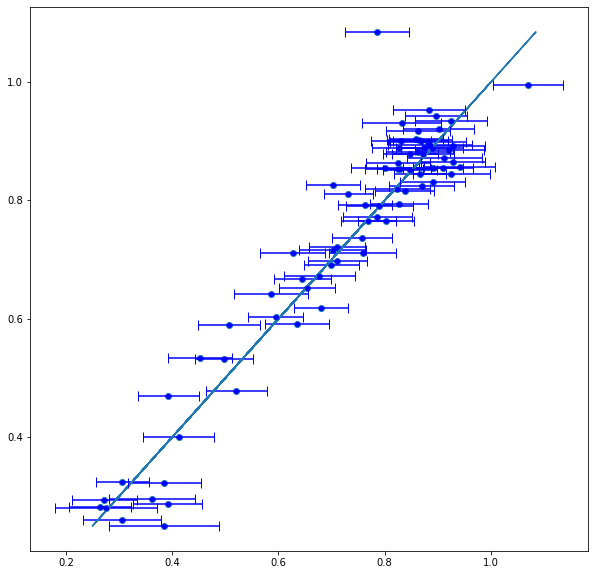

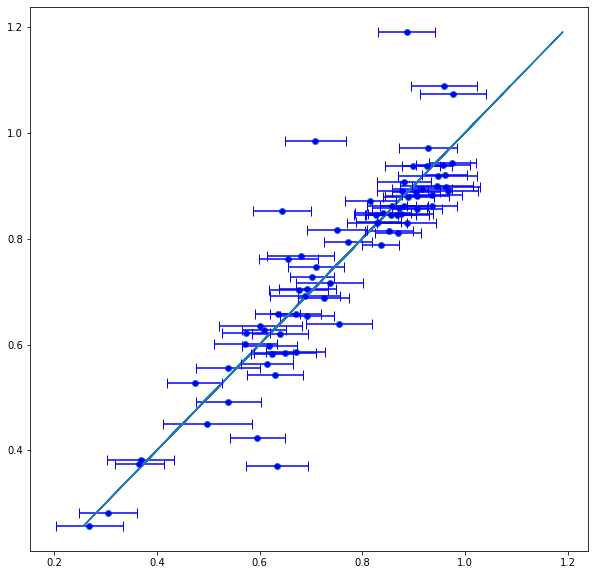

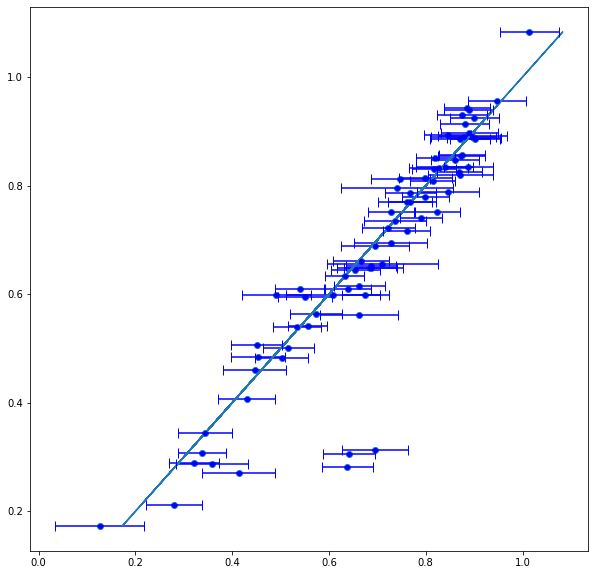

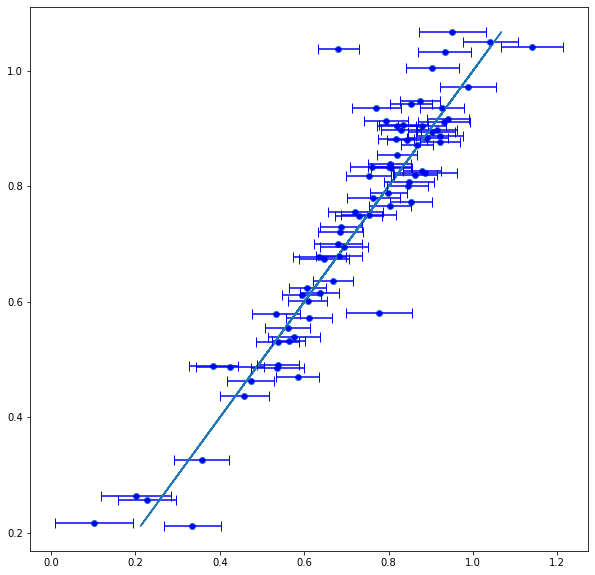

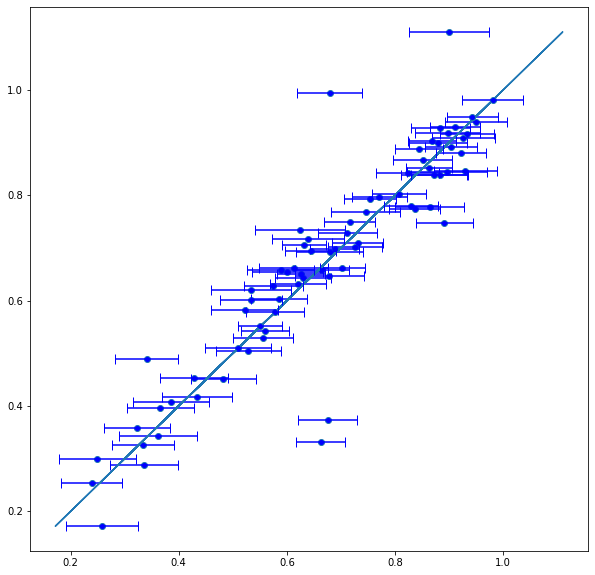

In [29]:
from sklearn.cluster import KMeans
from src.svgp import VBagg
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"


RMSE = []
MAPE = []
training_time = []

for k in range(5):
# k = 0
    train_indices = shuffled_indices[:k*75] + shuffled_indices[(k+1)*75:]
    test_indices = shuffled_indices[k*75: (k+1)*75]
    train_set = create_data_dict(data, train_indices, max_VOD, max_EVI)
    test_set = create_data_dict(data, test_indices, max_VOD, max_EVI)

    ## SVGP
    train_bag = MultiResolutionBagDataGenerator(train_set)

    # initialise by 1 element from each bag
    z1 = np.zeros((train_bag.num_bags, train_bag.dim_1))
    kmeans1 = KMeans(n_clusters=1)
    print("Calculating Inducing Points")
    for i, bag in tqdm(enumerate(train_bag.bags)):
        z1[i, :] = kmeans1.fit(train_bag[bag][-2][:train_bag[bag][0]]).cluster_centers_

    k1 = gpflow.kernels.SquaredExponential(active_dims=[i for i in range(213)])
    k2 = gpflow.kernels.SquaredExponential(active_dims=[i for i in range(213, 226)])
    ds_train = tf.data.Dataset.from_generator(train_bag.gen_bags, 
                                              output_types=(
                                                  tf.int64, 
                                                  tf.float64, 
                                                  tf.float64, 
                                                  tf.float64))
    m = VBagg(kernel=k1+k2, likelihood=gpflow.likelihoods.Gaussian(), inducing_variable=z1,num_data=train_bag.num_bags)

    # We turn off training for inducing point locations
    gpflow.set_trainable(m.inducing_variable, False)

    test_bag = MultiResolutionBagDataGenerator(test_set)
    
    maxiter = 20000
    print("Begin Training")
    t0 = time.time()
    logf = run_adam(m, test_bag, ds_train, N=train_bag.num_bags, iterations=maxiter, minibatch_size=5)
    t1 = time.time()

    y_pred = np.zeros(test_bag.num_bags)
    y_std = np.zeros(test_bag.num_bags)
    for i, bag in enumerate(test_set.keys()):
        mean_pred = m._build_variational_params(np.expand_dims(test_bag[bag][1], axis=0), 
                                np.expand_dims(test_bag[bag][2], axis=0))
        y_pred[i] = mean_pred[0]
        y_std[i] = np.sqrt(mean_pred[1])
    lower = np.reshape(1.96 * y_std, (test_bag.num_bags, 1))
    upper = np.reshape(1.96 * y_std, (test_bag.num_bags, 1))
    print(lower.shape, upper.shape)
    errors = np.concatenate((lower, upper), axis=1)
    errors = errors.T


    # plot predictions out-of-sample and save them
    plt.figure(figsize=(10, 10))
    plt.scatter(y_pred, test_bag.y)
    plt.plot(test_bag.y, test_bag.y)
    print("Test RMSE: ", np.sqrt(np.mean((y_pred - test_bag.y[:,0]) ** 2)))
    plt.errorbar(
        y_pred,
        test_bag.y,
        xerr=errors,
        fmt="o",
        ls="none",
        capsize=5,
        markersize=4,
        color="blue",
    )
    training_time.append(t1-t0)
    RMSE.append(np.sqrt(np.mean((y_pred - test_bag.y[:, 0]) ** 2)))
    MAPE.append(np.mean(np.abs(( y_pred - test_bag.y[:, 0] ) / test_bag.y[:, 0])))



In [30]:
json_file = json.dumps({"CV-RMSE": sum(RMSE) / 5, "CV-MAPE": sum(MAPE) / 5, 
                       "CV-sd-RMSE": sem(RMSE), "CV-sd-MAPE": sem(MAPE),
                        "Training Time": sum(training_time)/5, "Training Time sd": sem(training_time)})
                       
f = open('../../results/dr_paper/VBagg_CV.json', "w")
f.write(json_file)
f.close()

In [31]:
{"CV-RMSE": sum(RMSE) / 5, "CV-MAPE": sum(MAPE) / 5, 
                       "CV-sd-RMSE": sem(RMSE), "CV-sd-MAPE": sem(MAPE),
                        "Training Time": sum(training_time)/5, "Training Time sd": sem(training_time)}
                       

{'CV-RMSE': 0.07581893911085907,
 'CV-MAPE': 0.08495881550776034,
 'CV-sd-RMSE': 0.004108984318078328,
 'CV-sd-MAPE': 0.006471938507270588,
 'Training Time': 288.2721923351288,
 'Training Time sd': 1.1383144251451522}